In [1]:
from IPython.display import Image
Image(url="https://i.imgur.com/gDhvcuP.png")

In [2]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

In [3]:
ROWS = 6
COLS = 10
S = [ROWS-1, 0]
G = [ROWS-1, COLS-1]

In [4]:
class Cliff:
    
    def __init__(self):
        """
        Initialize a cliff instance
        """
        self.done = False
        self.pos = S
        self.board = np.zeros([ROWS, COLS])
        # set the location of the cliff
        self.board[ROWS-1, 1:-1] = -1
        
    def step(self, action):
        """
        Given an action, return the agent's next position
        """
        assert action in [0, 1, 2, 3]
        # up
        if action == 0:
            next_pos = [self.pos[0]-1, self.pos[1]]
        # down
        elif action == 1:
            next_pos = [self.pos[0]+1, self.pos[1]]
        # left
        elif action == 2:
            next_pos = [self.pos[0], self.pos[1]-1]
        # right
        else:
            next_pos = [self.pos[0], self.pos[1]+1]

        # make sure that the agent does not go out of bounds
        if next_pos[0] >= 0 and next_pos[0] < ROWS:
            if next_pos[1] >= 0 and next_pos[1] < COLS:
                self.pos = next_pos
        
        # reward per step
        reward = -5.0
        self.done = False
        
        if self.pos == G:
            self.done = True
            reward = 100
            print("Reached goal")
        
        if self.board[self.pos[0], self.pos[1]] == -1:
            self.done = True
            reward = -100.0
            print("Fell off cliff")
            
        return self.pos, reward, self.done
    
    def reset(self):
        """
        Resets the agent's position to the starting position
        """
        self.pos = S
        return self.pos
    
    def show(self):
        """
        Displays the cliff environment
        """
        for i in range(ROWS):
            print('----' * COLS + '-')
            out = '| '
            for j in range(COLS):
                if self.board[i, j] == -1:
                    token = 'x'
                if self.board[i, j] == 0:
                    token = 'o'
                if [i, j] == self.pos:
                    token = 'S'
                if [i, j] == G:
                    token = 'G'
                out += token + ' | '
            print(out)
        print('----' * COLS + '-')

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        """
        Initialize the DQN Agent
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9   
        self.epsilon = 1.0 
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99995 
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        """
        Builds a simple Q-Network composed of linear layers
        """
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Given a state, returns the action the agent takes
        """
        # randomly select action
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        # use Q-Network to predict action
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  

    def replay(self, batch_size):
        """
        Trains the Q-Network using experiences in the agent's memory
        """
        minibatch = random.sample(self.memory, batch_size)
        states, targets_f = [], []
        for state, action, reward, next_state, done in minibatch:
            # if done, set target = reward
            target = reward
            # if not done, predict future discounted reward with the Bellman equation
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target 
            # filtering out states and targets for training
            states.append(state[0])
            targets_f.append(target_f[0])
        history = self.model.fit(np.array(states), np.array(targets_f), epochs=1, verbose=0)
        # keeping track of loss
        loss = history.history['loss'][0]
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [6]:
env = Cliff()
state_size = 2 # state = (x, y) coordinate of agent's location
action_size = 4 # action: go up, down, left, or right
agent = DQNAgent(state_size, action_size)
# agent.load("./agent_weights.h5")
batch_size = 64
env.show()

-----------------------------------------
| o | o | o | o | o | o | o | o | o | o | 
-----------------------------------------
| o | o | o | o | o | o | o | o | o | o | 
-----------------------------------------
| o | o | o | o | o | o | o | o | o | o | 
-----------------------------------------
| o | o | o | o | o | o | o | o | o | o | 
-----------------------------------------
| o | o | o | o | o | o | o | o | o | o | 
-----------------------------------------
| S | x | x | x | x | x | x | x | x | G | 
-----------------------------------------


Fell off cliff
episode: 0/5, timestep: 0, epsilon: 1.0
HEATMAP FOR EPISODE 0
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]


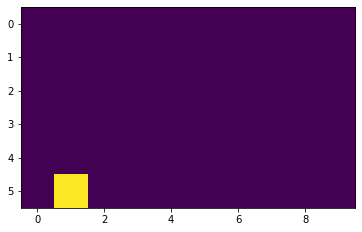

~~~~~~~~~
Time for episode 0 = 0m 0s
~~~~~~~~~
Fell off cliff
episode: 1/5, timestep: 2, epsilon: 1.0
HEATMAP FOR EPISODE 1
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [2 2 0 0 0 0 0 0 0 0]]


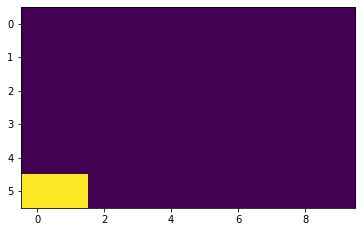

~~~~~~~~~
Time for episode 1 = 0m 0s
~~~~~~~~~
Time for episode 2 = 0m 0s
~~~~~~~~~
Fell off cliff
episode: 3/5, timestep: 6, epsilon: 1.0
HEATMAP FOR EPISODE 3
[[0 0 1 2 5 6 1 0 0 0]
 [1 0 2 1 3 2 0 0 0 0]
 [3 1 3 0 2 2 0 0 0 0]
 [6 3 2 0 1 2 0 0 0 0]
 [4 1 1 0 0 0 0 0 0 0]
 [3 3 0 0 0 0 0 0 0 0]]


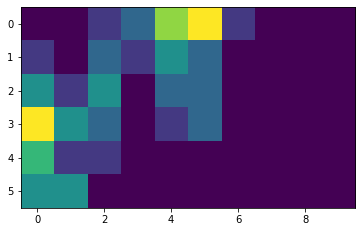

~~~~~~~~~
Time for episode 3 = 0m 0s
~~~~~~~~~
Fell off cliff
episode: 4/5, timestep: 1, epsilon: 1.0
HEATMAP FOR EPISODE 4
[[0 0 1 2 5 6 1 0 0 0]
 [1 0 2 1 3 2 0 0 0 0]
 [3 1 3 0 2 2 0 0 0 0]
 [6 3 2 0 1 2 0 0 0 0]
 [4 1 1 0 0 0 0 0 0 0]
 [4 4 0 0 0 0 0 0 0 0]]


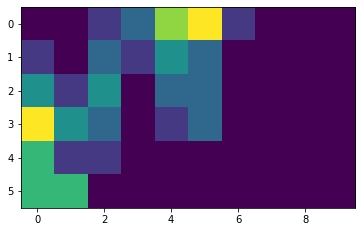

~~~~~~~~~
Time for episode 4 = 0m 0s
~~~~~~~~~


In [7]:
# Train the agent

EPISODES = 5 # change to 5000 if actually training
heatmap = np.zeros([ROWS, COLS])

for e in range(EPISODES):
    since = time.time()
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    for t in range(50): # change to 500 if actually training
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        
        # CREATE/SAVE HEATMAP
        heatmap[state[0][0]][state[0][1]] += 1
        np.savetxt("heatmap.txt", heatmap)
        
        if done:
            print("episode: {}/{}, timestep: {}, epsilon: {}".format(e, EPISODES, t, agent.epsilon)) 
            print("HEATMAP FOR EPISODE {}".format(e))
            print(heatmap.astype("int"))
            plt.imshow(heatmap)
            plt.show()
            print("~~~~~~~~~")
            break
        
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)
            # logging training loss every 10 timesteps
            if t % 10 == 0:
                print("episode: {}/{}, timestep: {}, epsilon: {}".format(e, EPISODES, t, agent.epsilon)) 
                print("HEATMAP FOR EPISODE {}".format(e))
                print(heatmap.astype("int"))
                plt.imshow(heatmap)
                plt.show()
                print("~~~~~~~~~")
    
    # agent.save("./agent_weights.h5")
    # print("saved weights at episode {}".format(e))
    print('Time for episode {} = {:.0f}m {:.0f}s'.format(e, (time.time() - since) // 60, (time.time() - since) % 60))
    print("~~~~~~~~~")

In [8]:
# Test the trained agent

# set epsilon to 0 to make the policy deterministic
# agent.epsilon = 0.0

# def show_route(states):
#     """
#     Shows the route the agent took from the start to the goal
#     """
#     board = np.zeros([ROWS, COLS])
#     # add cliff marked as -1
#     board[ROWS-1, 1:-1] = -1
#     for i in range(ROWS):
#         print('----' * COLS + '-')
#         out = '| '
#         for j in range(COLS):
#             token = ' '
#             if board[i, j] == -1:
#                 token = 'x'
#             if [i, j] in states:
#                 token = 'R'
#             if [i, j] == G:
#                 token = 'G'
#             if [i, j] == S:
#                 token = 'S'
#             out += token + ' | '
#         print(out)
#     print('----' * COLS + '-') 

# states = []
# state = env.reset()
# state = np.reshape(state, [1, state_size])
# action_map = {0: "up", 1: "down", 2: "left", 3: "right"}

# while True:
#     action = agent.act(state)
#     print("state: {} action: {}".format(state, action_map[action]))
#     next_state, reward, done = env.step(action)
#     states.append(next_state)
#     next_state = np.reshape(next_state, [1, state_size])
#     state = next_state
#     if done:
#         break
        
# show_route(states)